<a href="https://colab.research.google.com/github/kuan0808/Med_Conversation_NER/blob/master/medical_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd

import keras
from keras import Input
from keras.layers import Embedding, \
    GRU, Dense, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
import tensorflow as tf

import datetime

!pip install jieba
import jieba

from sklearn.model_selection \
    import train_test_split

In [ ]:
MAX_NUM_WORDS = 10000

NUM_CLASSES = 19

MAX_SEQUENCE_LENGTH = 5159

VALIDATION_RATIO = 0.1

NUM_EMBEDDING_DIM = 512

NUM_GRU_UNITS = 128

RANDOM_STATE = 42

label_to_index = {'name' : 0, 'location' : 1, 'time' : 2, 'contact' : 3, 'ID' : 4, \
                  'profession' : 5, 'biomarker' : 6, 'family' : 7, 'clinical_event' : 8, \
                  'special_skills' : 9, 'unique_treatment' : 10, 'account' : 11, 'organization' : 12, \
                  'education': 13, 'money' : 14, 'belonging_mark' : 15, 'med_exam' : 16, 'others' : 17, 'None' : 18}

index_to_label = {v: k for k, v in label_to_index.items()}

tokenizer = keras \
    .preprocessing \
    .text \
    .Tokenizer(num_words = MAX_NUM_WORDS, lower = False, filters = '&*#@$')

# Data Preprocess

In [ ]:
def preprocess_txt(path, is_trainset = False, valid_ratio = 0.1):
    contents = []
    labels = []
    with open(path, 'r', encoding='utf8') as f:
        raw_data=f.read().encode('utf-8').decode('utf-8-sig')
    articles = raw_data.split('\n\n--------------------\n\n')
    for article in articles:
        content = article.split('\n')[0]
        contents.append(content)
        if is_trainset:
            for label in article.split('\n')[2:]:
                annot = label.split('\t')
                labels.append([int(annot[0]), int(annot[1]), int(annot[2]), annot[4]])
    article_id = []
    tokenized_words = []
    start_pos = []
    end_pos = []
    for i in range(len(contents)):
        result = jieba.tokenize(contents[i])
        for tokenized_word, start, end in result:
            article_id.append(i)
            if tokenized_word != '......':
                tokenized_words.append(tokenized_word)
            else:
                tokenized_words.append('nan')
            start_pos.append(start)
            end_pos.append(end)
    dic = {'article_id' : article_id, 'tokenized_words' : tokenized_words, 'start_pos' : start_pos, 'end_pos': end_pos}
    df = pd.DataFrame(dic)
    if is_trainset:
        df['label_type'] = 'None'
        for label in labels:
            df.loc[(df.article_id == label[0]) & (label[1] <= df.start_pos) & (label[2] > df.start_pos), 'label_type'] = label[3]
    
    tokenizer.fit_on_texts(df.tokenized_words.values)
    df['trainset'] = df.tokenized_words.apply(lambda x: tokenizer.word_index[x])
    if is_trainset:
        df['label_type_num'] = df.label_type.apply(lambda x: label_to_index[x])
    train = df.groupby('article_id').trainset.apply(list).reset_index(name = 'sequence')
    if is_trainset:
        train = pd.merge(train, df.groupby('article_id').label_type_num.apply(list).reset_index(name = 'label'), on = 'article_id')
    start_end = list(zip(df.start_pos, df.end_pos))
    df['start_end'] = start_end
    train = pd.merge(train, df.groupby('article_id').start_end.apply(list).reset_index(name = 'start_end'), on = 'article_id')
    
    x_train = train.sequence
    x_train = keras \
        .preprocessing \
        .sequence \
        .pad_sequences(x_train, 
                    maxlen=MAX_SEQUENCE_LENGTH)
    x_pos = train.start_end
    x_pos = keras \
        .preprocessing \
        .sequence \
        .pad_sequences(x_pos, 
                    maxlen=MAX_SEQUENCE_LENGTH)
    x_train = np.array(x_train, dtype='float32')
    x_pos = np.array(x_pos, dtype='float32')
    if is_trainset:
        y_train = train.label
        y_train = keras \
            .preprocessing \
            .sequence \
            .pad_sequences(y_train, 
                   maxlen=MAX_SEQUENCE_LENGTH, value=18)
        y_train = np.array(y_train, dtype='float32')
        categor_method = lambda x: keras.utils.to_categorical(x)
        y_train = np.array([categor_method(y) for y in y_train])
        x_train, x_val, y_train, y_val = \
        train_test_split(
        x_train, y_train,
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE)
        print("Training Set")
        print("-" * 10)
        print(f"x_train: {x_train.shape}")
        print(f"y_train : {y_train.shape}")

        print("-" * 10)
        print(f"x_val:   {x_val.shape}")
        print(f"y_val :  {y_val.shape}")
        print("-" * 10)
        print("Test Set")
        return x_train, y_train, x_val, y_val
    return x_train, x_pos
    

In [ ]:
train_file_path='train_1_update.txt'

In [ ]:
x_train, y_train, x_val, y_val = preprocess_txt(train_file_path, is_trainset=True)
print(y_train.shape)
# print(np.argmax(y_train, axis=2))
# print(np.squeeze(np.argmax(y_train, axis=2).reshape(-1,1)))

Training Set
----------
x_train: (108, 5159)
y_train : (108, 5159, 19)
----------
x_val:   (12, 5159)
y_val :  (12, 5159, 19)
----------
Test Set
(108, 5159, 19)


In [ ]:
test_file_path = 'SampleData_deid.txt'

In [ ]:
x_test, x_pos= preprocess_txt(test_file_path, valid_ratio=0)
print(x_pos)

[[[   0.    0.]
  [   0.    0.]
  [   0.    0.]
  ...
  [2879. 2880.]
  [2880. 2881.]
  [2881. 2882.]]

 [[   0.    0.]
  [   0.    0.]
  [   0.    0.]
  ...
  [2726. 2728.]
  [2728. 2730.]
  [2730. 2731.]]

 [[   0.    0.]
  [   0.    0.]
  [   0.    0.]
  ...
  [1823. 1825.]
  [1825. 1826.]
  [1826. 1827.]]

 ...

 [[   0.    0.]
  [   0.    0.]
  [   0.    0.]
  ...
  [1826. 1828.]
  [1828. 1829.]
  [1829. 1830.]]

 [[   0.    0.]
  [   0.    0.]
  [   0.    0.]
  ...
  [2072. 2073.]
  [2073. 2074.]
  [2074. 2075.]]

 [[   0.    0.]
  [   0.    0.]
  [   0.    0.]
  ...
  [2020. 2021.]
  [2021. 2023.]
  [2023. 2024.]]]


# Model

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5159)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 5159, 512)         5120000   
_________________________________________________________________
gru_2 (GRU)                  (None, 5159, 128)         246528    
_________________________________________________________________
time_distributed (TimeDistri (None, 5159, 19)          2451      
Total params: 5,368,979
Trainable params: 5,368,979
Non-trainable params: 0
_________________________________________________________________


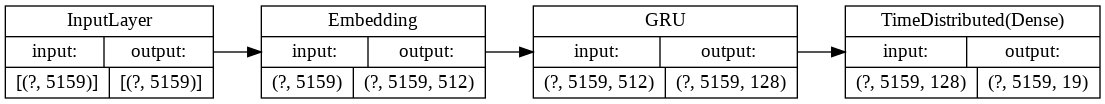

In [ ]:
input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='float32')

embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM, mask_zero=True, trainable=True)
embedded = embedding_layer(input)

gru = GRU(NUM_GRU_UNITS, return_sequences=True)
output = gru(embedded)

dense =  TimeDistributed(Dense(
    units=NUM_CLASSES, 
    activation='softmax'))
predictions = dense(output)

model = Model(inputs=input, outputs=predictions)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

## Model Fit


In [ ]:
BATCH_SIZE = 10

NUM_EPOCHS = 20

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x=x_train, 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(x_val, y_val),shuffle=True,callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 120s 11s/step - loss: 0.0088 - accuracy: 0.9898 - val_loss: 0.0112 - val_accuracy: 0.9853
Epoch 2/20
11/11 [==============================] - 117s 11s/step - loss: 0.0088 - accuracy: 0.9901 - val_loss: 0.0109 - val_accuracy: 0.9863
Epoch 3/20
11/11 [==============================] - 118s 11s/step - loss: 0.0077 - accuracy: 0.9913 - val_loss: 0.0106 - val_accuracy: 0.9863
Epoch 4/20
11/11 [==============================] - 118s 11s/step - loss: 0.0074 - accuracy: 0.9917 - val_loss: 0.0110 - val_accuracy: 0.9867
Epoch 5/20
11/11 [==============================] - 116s 11s/step - loss: 0.0070 - accuracy: 0.9923 - val_loss: 0.0116 - val_accuracy: 0.9854
Epoch 6/20
11/11 [==============================] - 117s 11s/step - loss: 0.0064 - accuracy: 0.9926 - val_loss: 0.0109 - val_accuracy: 0.9864
Epoch 7/20
11/11 [==============================] - 116s 11s/step - loss: 0.0062 - accuracy: 0.9926 - val_loss: 0.0117 - val_accuracy: 0.9865
Epoch 

In [ ]:
predictions = model.predict(x_test)

def predictions_to_csv(predics, pos_info, testset):
    # dataframe['Category'] = np.squeeze(np.argmax(predics, axis=2).reshape(-1,1))
    # dataframe['Category'] = dataframe['Category'].apply(lambda x: index_to_label[x])
    # submission = dataframe.loc[dataframe.Category != 'None', ['article_id', 'start_pos', 'end_pos', 'tokenized_words', 'Category']]
    # submission.columns = ['article_id', 'start_position', 'end_position', 'entity_text', 'entity_type']
    article_id = []
    start_pos = []
    end_pos = []
    category_list = []
    text = []
    for i in range(len(predics)):
        for j in range(len(predics[i])):
            article_id.append(i)
            category = np.argmax(predics[i][j])
            category = index_to_label[category]
            category_list.append(category)
            start_pos.append(pos_info[i][j][0])
            end_pos.append(pos_info[i][j][1])
            text.append(tokenizer.index_word.get(testset[i][j], ''))
    dic = {'article_id' : article_id, 'start_position' : start_pos, 'end_position' : end_pos, 'entity_text' : text, 'entity_type' : category_list}
    output = pd.DataFrame(dic)
    output = output.loc[output.entity_type != 'None', :]
    return output

In [ ]:
output = predictions_to_csv(predictions, x_pos, x_test)
output.entity_type.value_counts()
output.head(500)

,article_id,start_position,end_position,entity_text,entity_type
3177,0,31.0,33.0,紅字,time
3231,0,111.0,113.0,它會,location
3665,0,716.0,718.0,腰椎,med_exam
3740,0,832.0,834.0,腰椎,med_exam
3761,0,861.0,863.0,腰椎,med_exam
...,...,...,...,...,...
133768,25,1490.0,1492.0,回診,time
133826,25,1571.0,1573.0,單阿,time
133871,25,1635.0,1637.0,回診,time
133878,25,1647.0,1649.0,回診,time
